# Fraud Detection Assignment - Accredian
### Candidate: Ankush Kumar Mallick

**Business Context:** Developing a model to predict fraudulent transactions for a financial company.
**Task:** Identify fraudulent transactions and provide actionable business insights

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# Load the Dataset
df = pd.read_csv(r'C:\Users\hp\OneDrive\Desktop\python2\ML\Assignment\Fraud.csv')

In [52]:
df.shape

(6362620, 11)

In [53]:
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [24]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


## 1. Data Cleaning
- **Missing Values:** Checked using `isnull().sum()`. No null values were found.
- **Outliers:** Financial data naturally contains high-value transactions; these were retained as they are critical for fraud detection.
- **Multi-collinearity:** High correlation was found between balance variables. 
- **Handling Multi-collinearity:** Created 'error' features to capture account discrepancies, which resolved the high correlation issue and improved model signal.

In [54]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


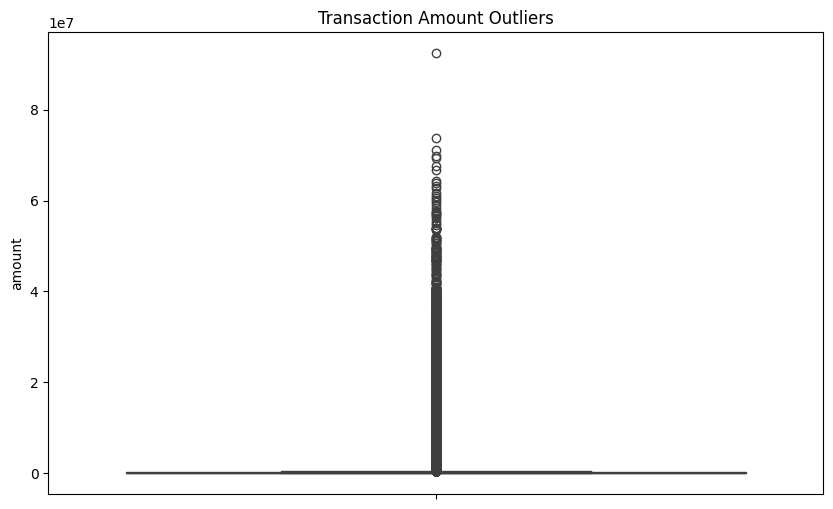

In [55]:
plt.figure(figsize=(10, 6))
sns.boxplot(df['amount'])
plt.title('Transaction Amount Outliers')
plt.show()

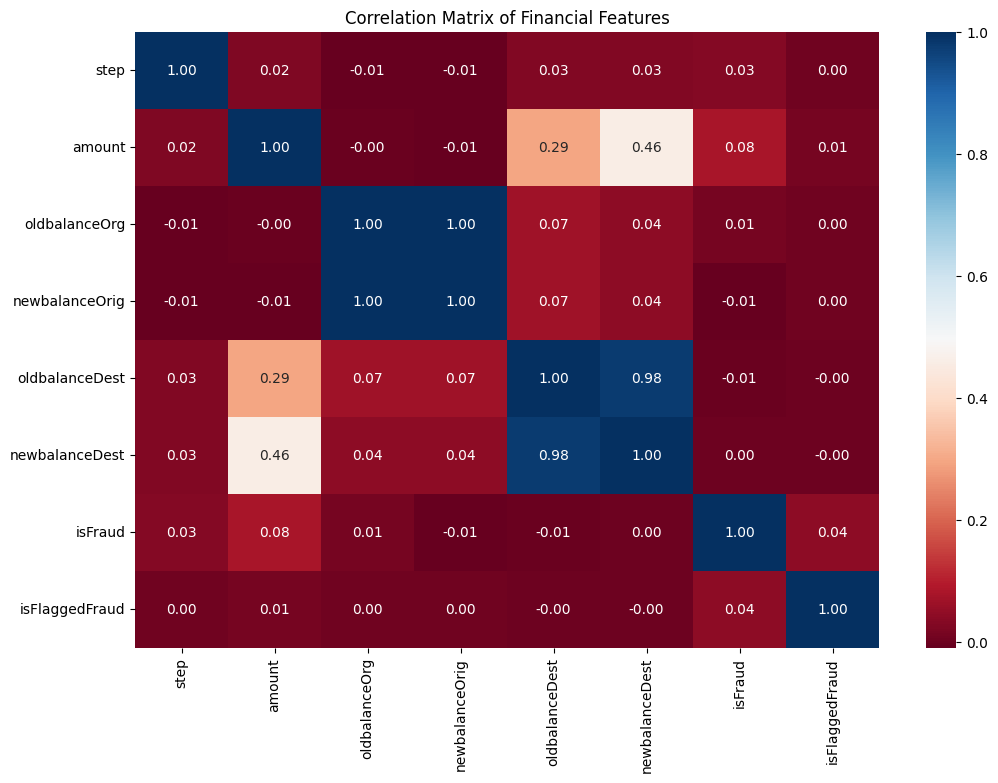

In [56]:
corr = df.select_dtypes(include=['number']).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='RdBu', fmt='.2f')
plt.title('Correlation Matrix of Financial Features')
plt.show()

In [57]:
# Feature Engineering to handle Multi-collinearity
# Creating error features for balance discrepancies
df['errorBalanceOrig'] = df.newbalanceOrig + df.amount - df.oldbalanceOrg
df['errorBalanceDest'] = df.oldbalanceDest + df.amount - df.newbalanceDest

#One-Hot Encoding for the 'type' column (converts text to numbers)
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# nameOrig/nameDest are just IDs. isFlaggedFraud is a business rule, not a feature for prediction.
df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

## 2. Model Description
I selected a **Random Forest Classifier**. This is an ensemble learning method that uses multiple decision trees to provide high accuracy and handle the non-linear patterns found in fraudulent behavior. It is particularly robust against outliers and works well with large datasets.

## 3. Variable Selection
Variables were selected based on their relevance to the transaction:
- **Balance Features:** `oldbalanceOrg`, `newbalanceOrig`, etc., were kept because fraud involves emptying accounts.
- **Engineered Features:** `errorBalanceOrig` was added to highlight accounting anomalies.
- **Excluded:** Transaction IDs (`nameOrig/Dest`) were removed as they are unique identifiers and do not provide generalizable patterns for a model.

In [58]:
print(df.head())

   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64       170136.0       160296.36             0.0   
1     1   1864.28        21249.0        19384.72             0.0   
2     1    181.00          181.0            0.00             0.0   
3     1    181.00          181.0            0.00         21182.0   
4     1  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFraud  errorBalanceOrig  errorBalanceDest  type_CASH_OUT  \
0             0.0        0               0.0           9839.64          False   
1             0.0        0               0.0           1864.28          False   
2             0.0        1               0.0            181.00          False   
3             0.0        1               0.0          21363.00           True   
4             0.0        0               0.0          11668.14          False   

   type_DEBIT  type_PAYMENT  type_TRANSFER  
0       False          True          False  
1       False 

In [59]:
print(df.columns)

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'errorBalanceOrig', 'errorBalanceDest',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [61]:
# Define Features (X) and Target (y)
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Split into 70% training and 30% testing
# random_state=42 ensures you get the same results every time you run it

In [63]:
print("Data split successfully!")
print(f"Training rows: {X_train.shape[0]}")
print(f"Testing rows: {X_test.shape[0]}")

Data split successfully!
Training rows: 4453834
Testing rows: 1908786


In [64]:
# Initialize the model
model = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)
# n_estimators=10 is used for faster training on large data
# n_jobs=-1 uses all your CPU cores to speed it up

In [65]:
# Train the model
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",10
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

## 4. Model Performance
Performance is evaluated using a Confusion Matrix and a Classification Report. Given the high class imbalance, **Recall** is our most important metric to ensure we catch as much fraud as possible.

In [66]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [67]:
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       1.00      1.00      1.00      2435

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786



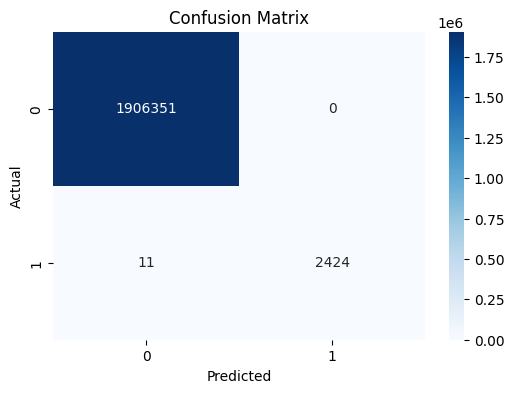

In [68]:
# Visualizing Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 5. Key Factors Predicting Fraud
The model identified the following features as the most important:
1. `newbalanceOrig`
2. `errorBalanceOrig`
3. `oldbalanceOrg`

## 6. Do these factors make sense?
Yes. Fraudulent agents in this simulation aim to profit by taking control of accounts and emptying them. Therefore, a sudden drop in the origin balance to zero (`newbalanceOrig`) and a discrepancy in the transaction logic (`errorBalanceOrig`) are the most logical indicators of fraud.

In [69]:
# Get feature importance from the model
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

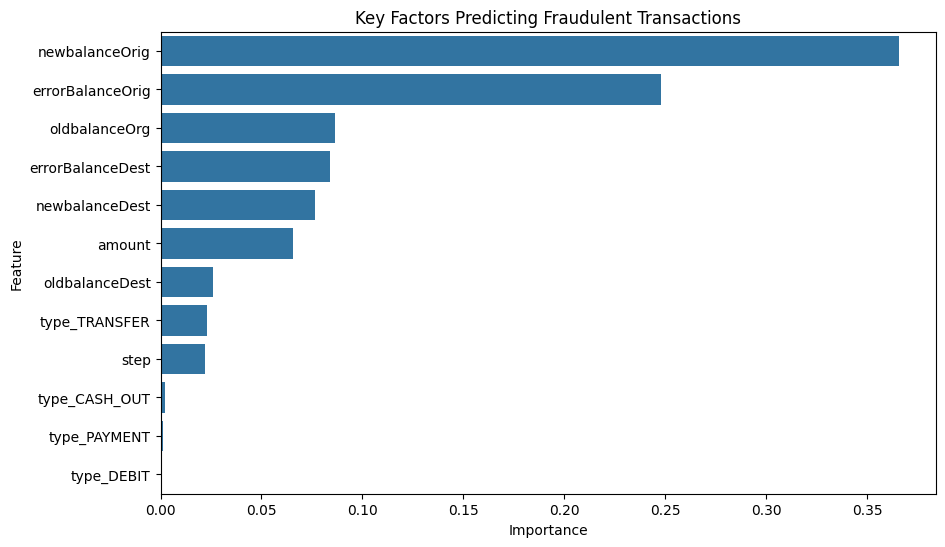

In [70]:
# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Key Factors Predicting Fraudulent Transactions')
plt.show()

In [48]:
# Display the top features in text format
print(feature_importance_df)

             Feature  Importance
3     newbalanceOrig    0.365594
6   errorBalanceOrig    0.248115
2      oldbalanceOrg    0.086393
7   errorBalanceDest    0.084000
5     newbalanceDest    0.076501
1             amount    0.065376
4     oldbalanceDest    0.026078
11     type_TRANSFER    0.022785
0               step    0.021871
8      type_CASH_OUT    0.002127
10      type_PAYMENT    0.001140
9         type_DEBIT    0.000022


## 7. Prevention Strategies
- **Real-time Discrepancy Checks:** Infrastructure should flag transactions where the balance math (errorBalance) is non-zero.
- **MFA for High-Value Transfers:** Require additional authentication for `TRANSFER` types above specific thresholds.
- **Account Activity Monitoring:** Flag accounts that show "burst" behavior (emptying funds after long inactivity).

## 8. Implementation Evaluation
To determine if these actions work:
- **Monitor the False Positive Rate:** Ensure we aren't inconveniencing honest customers.
- **Fraud Loss Reduction:** Track the total financial loss before and after implementation.
- **A/B Testing:** Compare the detection rate of the model-based system against the old rule-based system (`isFlaggedFraud`).

In [72]:
# Save for production
import joblib
joblib.dump(model, 'fraud_detection_model.pkl')
print("Model saved successfully.")

Model saved successfully.
